In [1]:

from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
import datasets
import torch
from datasets import Dataset, load_dataset, Sequence, ClassLabel, Features, Value
import evaluate
from preprocessing import preprocessing
from transformers import DataCollatorForTokenClassification
import numpy as np
import random
%load_ext autoreload
%autoreload 2


/opt/homebrew/Caskroom/miniconda/base/envs/a3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/martincarrasco/Documents/VU/Y1P4/ANLP/AdvancedNLP-VU/A3/utils.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/opt/homebrew/Caskroom/miniconda/base/envs/a3/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_

# 1. Preprocessing
First, we will define some paths and constant variables.
+ `DATA_NAME`: The name of the file to use for training
+ `MODE`: It can either be `train` or `test` depending on wether a model already exists or not
+ `PER_DS`: It is the percentage of the dataset that is sampled for training

In [3]:
TRAIN_FILE_NAME = 'en_ewt-up-train.conllu'
TEST_FILE_NAME = 'en_ewt-up-test.conllu'
DEV_FILE_NAME = 'en_ewt-up-dev.conllu'
MODE='test'
PER_DS = 0.05

## 1.1 Calling external libraries
We will call the preprocessing library with the `DATA_NAME` file that we used earlier. It should be located in the `data/raw` path for it to be recongnized. It will go over the the CONLL-U file and create a dataframe with it as well as organize the argument label and repeat the tokes as many times at there are predictes in a given sentence. Consequently, if there are 3 predicates in a sentence, there will be 3 rows with the same token per sentence with a different target label depending on if they are part of the argument or not and which argument they are for that predicate.

In [49]:
filename = TRAIN_FILE_NAME if MODE == 'train' else TEST_FILE_NAME if MODE == 'test' else DEV_FILE_NAME
df = preprocessing(filename)
label_list = list(df['label'].unique())

## 1.2 Agregation per sentence
We will agregate the dataframe based on `sentence_id`. This means that each row will now represent **one sentence**. Then, each row will contain a list of tokens for which corresponding lists of lemmas, predicates and labels are assigned. We perform this aggregation to facilitate then traning procedure, since we will to sequence to sequence tagging we want to pass a whole sequence and receive the output for it.

In [50]:
sent_df = df.groupby(['sentence_id']).agg(lambda x: x.tolist()).reset_index()

## 1.3  Dataset construction
The `huggingface` set of libraries provides a very good wrapper for processing datasets. For that reason, we will transform our data to that format by giving the types of the `features` and then passing our raw data to it

In [51]:
features = Features({
    'token_id': Sequence(feature=Value('float32')),
    'sentence_num': Sequence(feature=Value('int32')),
    'token': Sequence(feature=Value('string')),
    'lemma': Sequence(feature=Value('string')),
    'upos': Sequence(feature=Value('string')),
    'POS': Sequence(feature=Value('string')),
    'feats': Sequence(feature=Value('string')),
    'head': Sequence(feature=Value('string')),
    'deprel': Sequence(feature=Value('string')),
    'deps': Sequence(feature=Value('string')),
    'misc': Sequence(feature=Value('string')),
    'predicate': Sequence(feature=Value('string')),
    'predicate_token': Sequence(feature=Value('string')),
    'predicate_token_id': Sequence(feature=Value('int32')),
    'sentence_id': Value('int32'),
    'label': Sequence(feature=ClassLabel(names=label_list)),

})

ds = Dataset.from_pandas(sent_df[list(features.keys())], features=features)


# 1.4 Dataset filtering
Here we sample $k$ observations uniformly from the dataset, where $k=N*\alpha$ and $\alpha$ is `PER_DS` or the porcentage of the dataset we want to use for training. 

In [7]:
ds = ds.select(random.sample(range(len(ds)), int(len(ds)*PER_DS)))
len(ds)

248

# 1.5 Tokenization 
To perform tokenization we use the BERT base tokenizer from the `bert-base-uncased` model, so that is the standard BERT implementation without separate tokens for word cases. 

In [7]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
SEP_TOKEN_ID = tokenizer.all_special_ids[tokenizer.all_special_tokens.index('[SEP]')]

# 1.5.1 Actual tokenization and alignment
Here we call a function that will return a dataset in terms of `input_ids` and `attention_masks`. It will construct the proposed input as **CITE**, where we have `[CLS] sent [SEP] pred [SEP]`, giving the model the whole sentence and then the predicate at the end of the sentence. It will also construt the corresponding true labels on this, assigning the tokens to the true labels. Words we do not want to predict a label for are marked with an integer that is generally $-100$.

In [7]:
from utils import tokenize_and_align_labels
ex_sent_row = ds[0]
predicate = ex_sent_row['predicate_token'][0]
ex_sent = ex_sent_row['token']

Now we are going to inspect how does our tokenization and alignment works. First, we check how the `predicate` is tokenized. First we take a look at the `predicate`. We pick the first one because according to our implementation it will contained a repeated list of predicates.

In [11]:
predicate

'were'

Now we are going to see how its tokenized

In [12]:
tok_predicate = tokenizer([predicate], is_split_into_words=True)
tok_predicate

{'input_ids': [101, 2020, 102], 'token_type_ids': [0, 0, 0], 'attention_mask': [1, 1, 1]}

Event though our predicate is only one word, the tokenization is returning different ids. Lets look closer.

In [13]:
tokenizer.convert_ids_to_tokens(tok_predicate['input_ids'])

['[CLS]', 'were', '[SEP]']

We see know that it has been encoded as 2 *special tokens* plus the actual word has been divided into 3 sub-tokens. Let's look  at what happens if we construct our input sentence by appending the `predicate` to the `sentence`. Also notice we will apply `truncation` and `padding`. Truncation will remove tokens after token $64$ and `padding` will ensure all the resulting tokenized sentences have the same length.

In [14]:
tok_whole = tokenizer(ex_sent, [predicate], padding='max_length', max_length=64, truncation=True, is_split_into_words=True)

We can see that the amount of tokens after *tokenization* has grown. (also because of the PAD token)

In [15]:
print(len(tok_whole['input_ids']), len(ex_sent) + 1)

64 9


Here we can see the sentence turned back into words.

In [16]:
tokenizer.convert_ids_to_tokens(tok_whole['input_ids'])

['[CLS]',
 'four',
 'months',
 'later',
 ',',
 'we',
 'were',
 'married',
 '.',
 '[SEP]',
 'were',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

We can see that `predicate` has been appended to the end corrently. Note that also `token_type_ids` will change and instead of containing just 0s will contain 1s for our next word. Notice the `[PAD]` token at the end.

Next, we will see how the labeling changes, since the output is also a number, we need to map our outputs to the appropriate labels. `word_ids` will return a list which has an index for each token and the word it respresents. If it is a *subtoken* it will be repeated and if its a special token it will be `None`.

In [17]:
len(tok_whole.word_ids())

64

To construct our labels, we only care about labeling the sentence that comes first so we need to construct a way to identify the first set of tokens and discard the rest. For this, we can tokenize the sentence again and just set all the other tokens to a value ignored by PyTorch $(-100)$

In [20]:
tok_sent_alone = tokenizer(ex_sent, is_split_into_words=True)
label_ids = []

for i, word_idx in enumerate(tok_whole.word_ids()):
    if word_idx is None:
        # If it is a special token do not add a label
        label_ids.append(-100)
    elif i >= len(tok_sent_alone['input_ids']):
        # If the token is part of the predicate do not add a label
        label_ids.append(-100)
    else: 
        # Set the label of the first token of each word
        label_ids.append(ex_sent_row['label'][word_idx])
label_names = ds.features['label'].feature.names
decoded_labels = [label_names[idx] if idx != -100 else 'O' for idx in label_ids]
(len(decoded_labels), len(tok_whole['input_ids']))

(64, 64)

Now they have the same length and on a closer look we will see that it only contains labels for the sentence.

In [21]:
decoded_labels

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'V',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

Now we apply a map to calculate that for every row in our `Dataset`

In [9]:
from utils import tokenize_and_align_labels
tokenized_datasets = ds.map(lambda x: tokenize_and_align_labels(tokenizer, x))

Map: 100%|██████████| 4799/4799 [00:03<00:00, 1520.03 examples/s]


Here we can look at the  labels of the first row in the dataset already tokenized

In [23]:
tokenized_datasets['labels'][0]

[-100,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100]

# 2 Baseline model training
Now we specify some general information about the model we are going to train and the hyper-parameters we will use.

+ `LR`: Learning rate for the weights (amount of adjustment to the gradients on update of weights)
+ `EPOCHS`: The full runs we do on the training data 
+ `WEIGHT_DECAY`: A normalization parameter applied to the weights each iteration
+ `BATCH_SIZE`: The amount of batches where to sum of gradients before performing an update. It can be though of like the **step-size**

In [24]:
task = 'SRL'
BATCH_SIZE = 32
model_name = 'bert-base-uncased'
LR =2e-5
EPOCHS = 3
WEIGHT_DECAY = 0.01

The `TrainerArgument` class will let of specify all this information as well as a model name to put our model on the Hub

In [25]:
from transformers import DataCollatorForTokenClassification


args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    push_to_hub=False,
)

model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(label_list))

data_collator = DataCollatorForTokenClassification(tokenizer)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 2.1 Model training
Now we actually get to training. We remove irrelevant columns from the dataset and pass all of our information to the actual trainer. Then we run the training and save the model

In [26]:
from utils import compute_metrics
td = tokenized_datasets.remove_columns(ds.column_names)
trainer = Trainer(
    model,
    args,
    train_dataset=td,
    eval_dataset=td,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=lambda x: compute_metrics(x, label_list),
)


In [29]:
trainer.train()
trainer.save_model("bert_model_dev")

 33%|███▎      | 8/24 [00:10<00:14,  1.10it/s]

{'eval_loss': 0.8812035322189331, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8473338203067933, 'eval_runtime': 1.9766, 'eval_samples_per_second': 125.467, 'eval_steps_per_second': 4.047, 'epoch': 1.0}


 67%|██████▋   | 16/24 [00:27<00:11,  1.38s/it]

{'eval_loss': 0.8059567809104919, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8473338203067933, 'eval_runtime': 2.2429, 'eval_samples_per_second': 110.57, 'eval_steps_per_second': 3.567, 'epoch': 2.0}


100%|██████████| 24/24 [00:43<00:00,  1.81s/it]


{'eval_loss': 0.7894327640533447, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8473338203067933, 'eval_runtime': 2.0201, 'eval_samples_per_second': 122.767, 'eval_steps_per_second': 3.96, 'epoch': 3.0}
{'train_runtime': 43.4848, 'train_samples_per_second': 17.109, 'train_steps_per_second': 0.552, 'train_loss': 0.8926275571187338, 'epoch': 3.0}


# 3 Base model inference
In this step we load the test data from CONLL-U and test the labeling capabilities. We will test the labeling of arguments, their identification and the labeling of predicates as well (`V`). We will then plot these labelings and look at the scores.
For now, we use the `classification_report` of Scikit-Learn since the `seqeval` method of HuggingFace is broker if you do not want to evaluate `NER`.

First, we perform the dataset preprocessing and load the `tokenizer` from our fine-tunned model

In [6]:
from transformers import AutoTokenizer
from utils import tokenize_and_align_labels
MODEL_NAME = 'bert_baseline_model_train'
filename = TRAIN_FILE_NAME if MODE == 'train' else TEST_FILE_NAME if MODE == 'test' else DEV_FILE_NAME
df = preprocessing(filename)
sent_df = df.groupby(['sentence_id']).agg(lambda x: x.tolist()).reset_index()
label_list = list(df['label'].unique())

features = Features({
    'token_id': Sequence(feature=Value('float32')),
    'sentence_num': Sequence(feature=Value('int32')),
    'token': Sequence(feature=Value('string')),
    'lemma': Sequence(feature=Value('string')),
    'upos': Sequence(feature=Value('string')),
    'POS': Sequence(feature=Value('string')),
    'feats': Sequence(feature=Value('string')),
    'head': Sequence(feature=Value('string')),
    'deprel': Sequence(feature=Value('string')),
    'deps': Sequence(feature=Value('string')),
    'misc': Sequence(feature=Value('string')),
    'predicate': Sequence(feature=Value('string')),
    'predicate_token': Sequence(feature=Value('string')),
    'predicate_token_id': Sequence(feature=Value('int32')),
    'sentence_id': Value('int32'),
    'label': Sequence(feature=ClassLabel(names=label_list)),

})

ds = Dataset.from_pandas(sent_df[list(features.keys())], features=features)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, local_files_only=True)
tokenized_datasets = ds.map(lambda x: tokenize_and_align_labels(tokenizer, x))

Map: 100%|██████████| 14397/14397 [00:20<00:00, 706.78 examples/s] 


In [58]:
import pandas as pd
from sklearn.metrics import classification_report
import os
from itertools import chain

trained_model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME, local_files_only=True).to('cpu')

label_list = list(ds.features['label'].feature.names)
with torch.inference_mode():

    tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    input_ids = tokenized_datasets['input_ids']#[:100]#.expand(1, -1)
    attention_mask = tokenized_datasets['attention_mask']#[:100]#.expand(1, -1)
    logits = trained_model(input_ids=input_ids, attention_mask=attention_mask).logits
    predicted_token_class_ids = torch.argmax(logits, dim=2).cpu()


    predictions = predicted_token_class_ids
    labels = tokenized_datasets['labels']#[:100]
    proc_y_true = []
    proc_y_pred = []

    for prediction, label in zip(predictions, labels):
        for p, l in zip(prediction, label):
            if l != -100:
                proc_y_true.append(label_list[l])
                proc_y_pred.append(label_list[p.item()])

    true_labels = proc_y_true
    true_predictions = proc_y_pred 

    cr = classification_report(true_labels, true_predictions, labels=label_list, zero_division=0, output_dict=True)
    df = pd.DataFrame.from_dict(cr)
    df.to_csv(f'{MODEL_NAME}.csv')


trained_model = AutoModelForTokenClassification.from_pretrained("bert_baseline_model_train", local_files_only=True).to('cpu')

label_list = list(ds.features['label'].feature.names)
with torch.inference_mode():

    tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    input_ids = tokenized_datasets['input_ids'][:10]#.expand(1, -1)
    attention_mask = tokenized_datasets['attention_mask'][:10]#.expand(1, -1)
    logits = trained_model(input_ids=input_ids, attention_mask=attention_mask).logits
    predicted_token_class_ids = torch.argmax(logits, dim=2).cpu()


    predictions = predicted_token_class_ids
    labels = tokenized_datasets['labels'][:10]
    proc_y_true = []
    proc_y_pred = []

    true_labels = []
    true_predictions = []

    for i, (prediction, label) in enumerate(zip(predictions, labels)):
        tokens = tokenized_datasets['token'][i]
        tok_tokens = tokenizer(tokens, is_split_into_words=True, padding='max_length', max_length=64, truncation=True)
        word_ids = list(tok_tokens.word_ids())
        last_word_id = -1
        last_labels = -1
        last_predictions = []

        for j, (p, l) in enumerate(zip(prediction, label)):
            word_id = word_ids[j]
            if l == -100:
                continue
            if last_word_id != word_id:
                if last_word_id == -1:
                    last_labels = l
                    last_predictions.append(p.item())
                    last_word_id = word_id
                    continue
                most_occur = max(last_predictions, key=last_predictions.count)

                # Add the word to the list
                true_labels.append(label_list[last_labels])
                true_predictions.append(label_list[most_occur])

                # Reset the list
                last_labels = -1
                last_predictions = []
            last_labels = l
            last_predictions.append(p.item())
            last_word_id = word_id


a = pd.DataFrame.from_dict(classification_report(true_labels, true_predictions, labels=label_list, zero_division=0, output_dict=True))
a.to_csv('metrics_bert_test.csv')

# 3.1 Results of base model
Here we can see the results of the base model from running in the test set. First, we can see the *precision*, *recall* and *F1* for each of the classes along with their averages using either **macro** or **weighted** aggregation methods.

The Figure shows that the models ability to predict that something is not an argument is very good, with an *F1* score of $0.97$. `ARGM-TMP` and `ARGM-NEG` are among the arguments git a high score in comparison with the others, notably `ARGM-NEG` has a $0.71$ as *F1* score. The Figure also shows that arguments like `ARG1` and `ARG2` are predicted but very badly predicted and `ARG0` is not predicted at all. For all other arguments there is a score of $0$. Meaning that the model did not make any predictions with respect to them.

Overall, the **macro** average of *F1* is $0.051$. However, the **weighted** average tells another story. By weighting in the amount of times a particular lavel appears the *F1* is actually $0.81$. It is also worth noting if we look at the *support* column that many labels appear less than 100 times in the whole dataset. 

<Axes: >

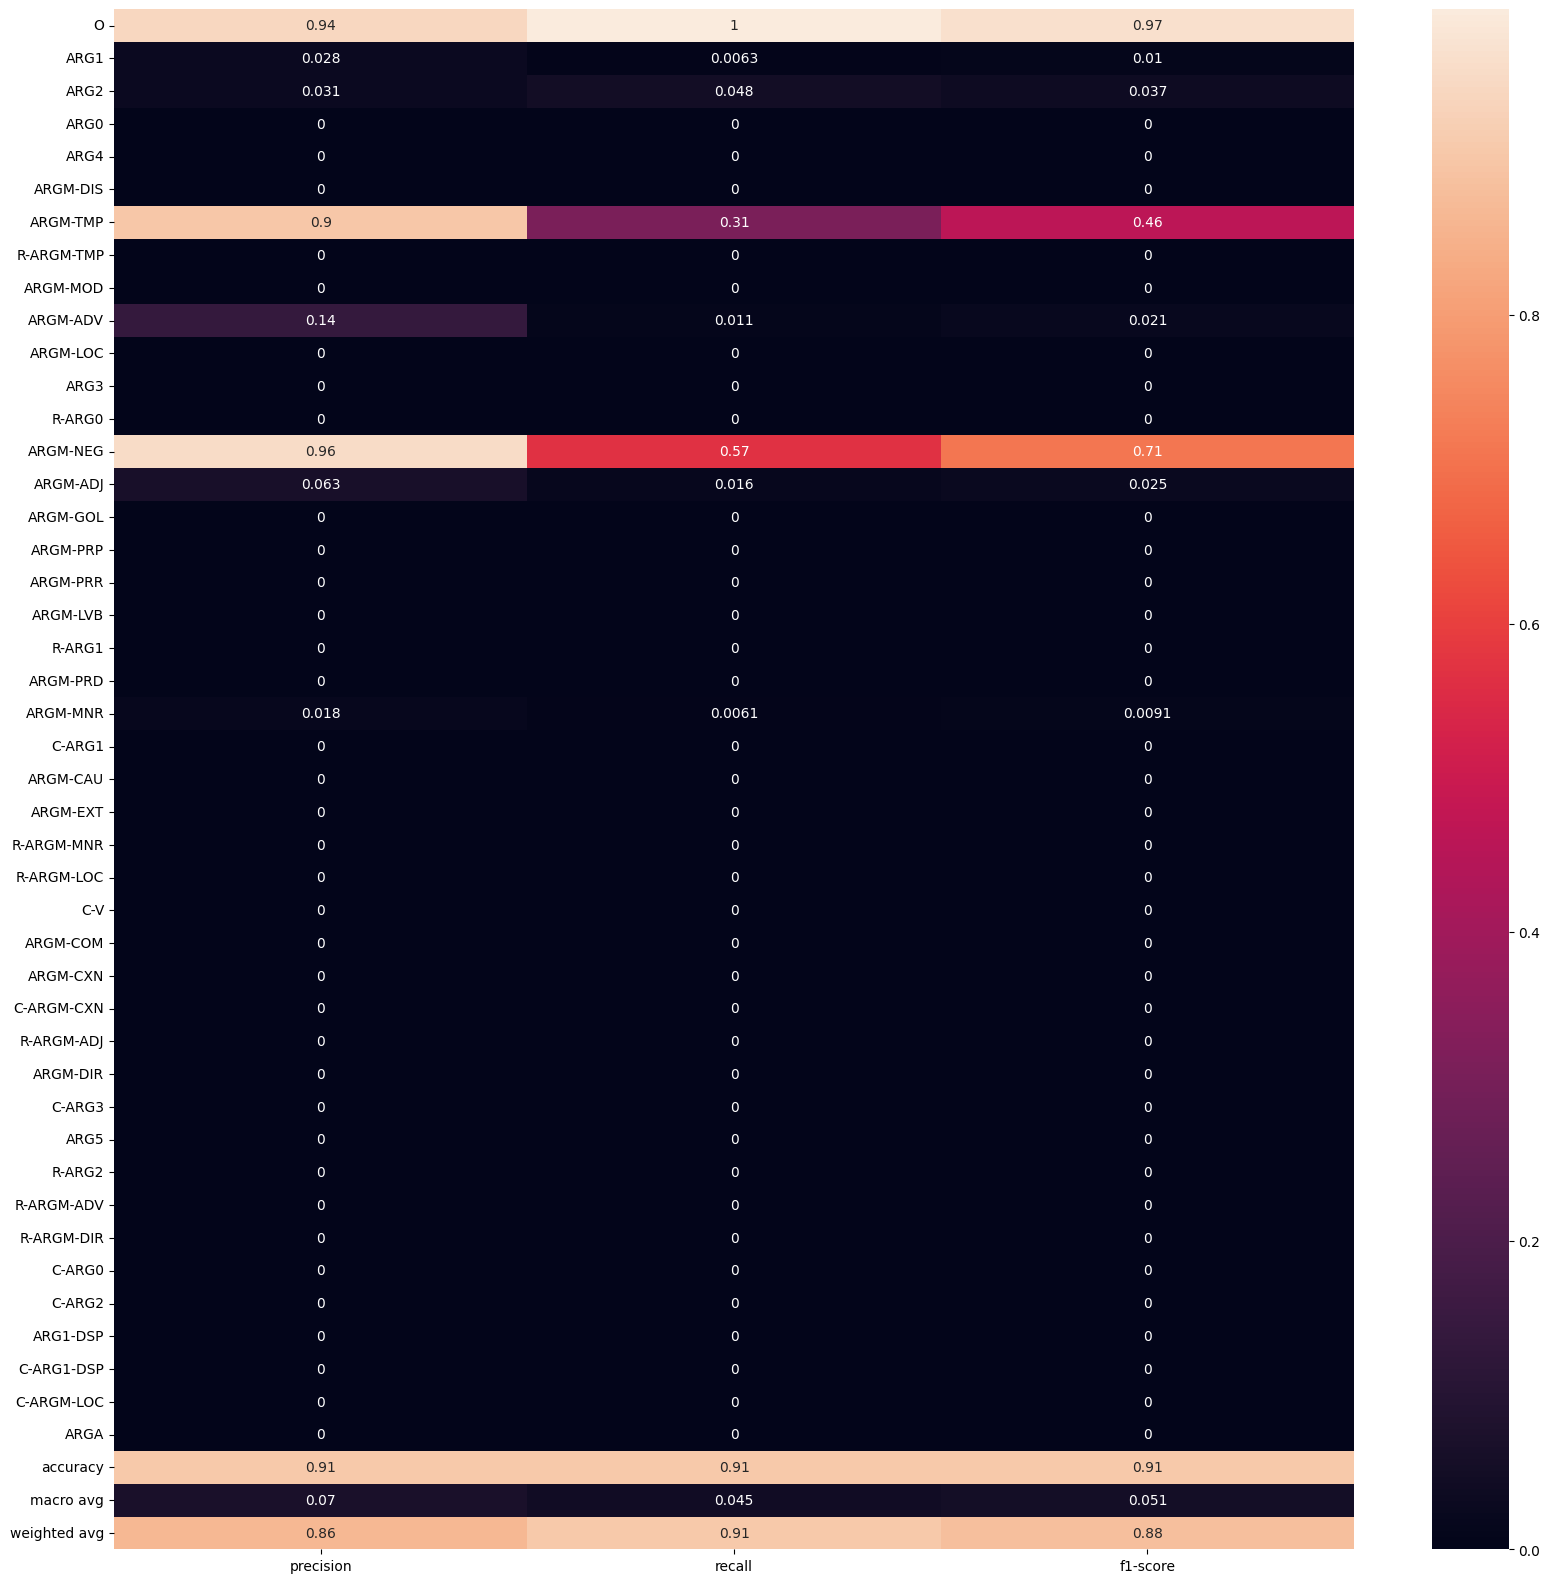

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = [20, 20]

df = pd.read_csv('metrics_bert_base.csv', index_col=0)
sns.heatmap(df.iloc[:-1, :].T, annot=True)

# 4 Advanced model
Our advanced model is based on NegBERT **CITE**.  NegBERT uses an annotation schema where certain groups of words are anotated of the labels with the aim of incorporating more information about *negation cues* into the model. According to the authors, this would in turn allow for better cue detection and span detection. We are trying to achieve something similar in the baseline model by appending the predicate at the end, however we do not use a MLP as an additionaly head of the output of the model. However, we will add more information to the input adding the base form of the predicate after the baseline. Thus resulting in `[CLS] sent [SEP] pred pred_base [SEP]` where `pred_base` would be the lemma of the predicate and the classification by PropBank.

To do this we only need to modify our existing utility function for creating the tokenized dataset and add some more steps to it. With that, we just change the following

In [69]:
row = ds[0]

tok_base = tokenizer(row['token'], is_split_into_words=True)
tok_pred_word = tokenizer(row['predicate_token'], is_split_into_words=True)
tok_pred_base = tokenizer(row['predicate'], is_split_into_words=True)




tok_in = tokenizer(row['token'], [row['predicate_token'][0], row['predicate'][0]], is_split_into_words=True)
tokenizer.convert_ids_to_tokens(tok_in['input_ids'])

['[CLS]',
 'four',
 'months',
 'later',
 ',',
 'we',
 'were',
 'married',
 '.',
 '[SEP]',
 'were',
 'be',
 '.',
 '03',
 '[SEP]']

We see this simple change already gives us the desire results. We proceed to test it.

In [ ]:
from utils import tokenize_and_align_labels_2
tokenized_datasets_2 = ds.map(lambda x: tokenize_and_align_labels_2(tokenizer, x))

We can reuse the training arguments from before, we will just reset them.

In [ ]:

args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    push_to_hub=False,
)

model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(label_list))

data_collator = DataCollatorForTokenClassification(tokenizer)


Now we define a new trainer and make a copy from the dataset that we already used and proceed to training

In [ ]:

from utils import compute_metrics
td_2 = tokenized_datasets_2.remove_columns(ds.column_names)
trainer_2 = Trainer(
    model,
    args,
    train_dataset=td_2,
    eval_dataset=td_2,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=lambda x: compute_metrics(x, label_list),
)

trainer_2.train()
trainer_2.save_model("bert_model_advanced")


# 4.1 Model results
 

In [ ]:

from transformers import AutoTokenizer
from utils import tokenize_and_align_labels
MODEL_NAME = 'bert_advanced_model_train'
filename = TRAIN_FILE_NAME if MODE == 'train' else TEST_FILE_NAME if MODE == 'test' else DEV_FILE_NAME
df = preprocessing(filename)
sent_df = df.groupby(['sentence_id']).agg(lambda x: x.tolist()).reset_index()
label_list = list(df['label'].unique())

features = Features({
    'token_id': Sequence(feature=Value('float32')),
    'sentence_num': Sequence(feature=Value('int32')),
    'token': Sequence(feature=Value('string')),
    'lemma': Sequence(feature=Value('string')),
    'upos': Sequence(feature=Value('string')),
    'POS': Sequence(feature=Value('string')),
    'feats': Sequence(feature=Value('string')),
    'head': Sequence(feature=Value('string')),
    'deprel': Sequence(feature=Value('string')),
    'deps': Sequence(feature=Value('string')),
    'misc': Sequence(feature=Value('string')),
    'predicate': Sequence(feature=Value('string')),
    'predicate_token': Sequence(feature=Value('string')),
    'predicate_token_id': Sequence(feature=Value('int32')),
    'sentence_id': Value('int32'),
    'label': Sequence(feature=ClassLabel(names=label_list)),

})

ds = Dataset.from_pandas(sent_df[list(features.keys())], features=features)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, local_files_only=True)
tokenized_datasets = ds.map(lambda x: tokenize_and_align_labels_2(tokenizer, x))

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report
import os
from itertools import chain

trained_model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME, local_files_only=True).to('cpu')

label_list = list(ds.features['label'].feature.names)
with torch.inference_mode():

    tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    input_ids = tokenized_datasets['input_ids']#[:100]#.expand(1, -1)
    attention_mask = tokenized_datasets['attention_mask']#[:100]#.expand(1, -1)
    logits = trained_model(input_ids=input_ids, attention_mask=attention_mask).logits
    predicted_token_class_ids = torch.argmax(logits, dim=2).cpu()


    predictions = predicted_token_class_ids
    labels = tokenized_datasets['labels']#[:100]
    proc_y_true = []
    proc_y_pred = []

    for prediction, label in zip(predictions, labels):
        for p, l in zip(prediction, label):
            if l != -100:
                proc_y_true.append(label_list[l])
                proc_y_pred.append(label_list[p.item()])

    true_labels = proc_y_true
    true_predictions = proc_y_pred 

    cr = classification_report(true_labels, true_predictions, labels=label_list, zero_division=0, output_dict=True)
    df = pd.DataFrame.from_dict(cr)
    df.to_csv(f'{MODEL_NAME}.csv')